#Completing an image using AI
Subject : "your challenge, shall you accept it, is to create an AI completing the ulam picture created by the following code"

#Creating the Ulam Spiral (I changed the shape of the image from (n+4, n+4) to (n+1, n+1) for better pattern extraction)



In [1]:
pip install fire Pillow

     |████████████████████████████████| 92kB 3.6MB/s 
  Created wheel for fire: filename=fire-0.4.0-py2.py3-none-any.whl size=115928 sha256=5483def2a6b84a887d059ed1022dad4442db55b7c332bb99763a01ba1c341f9e
  Stored in directory: /root/.cache/pip/wheels/af/19/30/1ea0cad502dcb4e66ed5a690279628c827aea38bbbab75d5ed
Successfully built fire


In [2]:
import json
import math
from fire import Fire
from PIL import Image

ULA_SIZE = 100

def is_prime(n):
    if n == 2:
        return True

    if n < 2 or n % 2 == 0:
        return False

    for i in range(3, 1 + int(math.sqrt(n)), 2):
        if (n % i) == 0:
            return False

    return True


def primes(n):
    p = [2]
    for i in range(3, n, 2):
        if is_prime(i) is True:
            p.append(i)

    return p


def ula(n, outputpath):
    image = Image.new("L", (n + 1, n + 1))
    pix = image.load()
    directions_str = ["up", "right", "down", "left"]
    directions = [(0, -1), (1, 0), (0, 1), (-1, 0)]

    direction = 3
    length = 0
    turn_length = 1
    color = 0
    position = (int(n / 2), int(n / 2))
    print(position)
    prime_count = 0
    for i in range(0, n * n):
        if is_prime(i) is True:
            color = 0
            prime_count += 1
        else:
            color = 255
        image.putpixel(position, (color))
        length += 1

        if length >= turn_length:
            direction = (direction + 1) % 4

            length = 1
            if (direction % 2) == 0:
                turn_length += 1

        position = (
            position[0] + directions[direction][0],
            position[1] + directions[direction][1],
        )

    image.putpixel((int(n / 2), int(n / 2)), 128)

    image.save(outputpath)


In [3]:
ula(ULA_SIZE,'100.png')

(50, 50)


#Challenge interpretation
I thought of 3 different ways to interpret "completing"

##"Completing" the image by adding pixels at the edge of the spiral picture
-WaveFunctionCollapse (https://github.com/mxgmn/WaveFunctionCollapse)

-Globally and Locally Consistent Image Completion (http://iizuka.cs.tsukuba.ac.jp/projects/completion/data/completion_sig2017.pdf) -> Works well for image INTERpolation, works a lot worse for image EXTRApolation (that's what the researchers say in their paper). So I won't go down this path

##"Completing" the image by adding colors or by giving it a certain style for example
-NN style transfer (https://www.tensorflow.org/tutorials/generative/style_transfer)

-Deep Dream (https://www.tensorflow.org/tutorials/generative/deepdream) -> Style transfer is a much more general technique so I won't use deep Dream

##Using a NN to identify prime numbers, and using the NN instead of the "is_prime" function to generate the image
-> The spirit of the challenge is not to generate a new image completely, so i will not go down this path either

#Style transfer ( taken directly from the Tensorflow tutorials website : https://www.tensorflow.org/tutorials/generative/style_transfer)

In [4]:
import os
import tensorflow as tf
# Load compressed models from tensorflow_hub
os.environ['TFHUB_MODEL_LOAD_FORMAT'] = 'COMPRESSED'

import IPython.display as display

import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams['figure.figsize'] = (12, 12)
mpl.rcParams['axes.grid'] = False

import numpy as np
import PIL.Image
import time
import functools

def tensor_to_image(tensor):
  tensor = tensor*255
  tensor = np.array(tensor, dtype=np.uint8)
  if np.ndim(tensor)>3:
    assert tensor.shape[0] == 1
    tensor = tensor[0]
  return PIL.Image.fromarray(tensor)


In [5]:
content_path = "100.png"
style_path = tf.keras.utils.get_file('kandinsky5.jpg','https://storage.googleapis.com/download.tensorflow.org/example_images/Vassily_Kandinsky%2C_1913_-_Composition_7.jpg')


196608/195196 [==============================] - 0s 0us/step


In [6]:
def load_img(path_to_img):
  max_dim = 512
  img = tf.io.read_file(path_to_img)
  img = tf.image.decode_image(img, channels=3)
  img = tf.image.convert_image_dtype(img, tf.float32)

  shape = tf.cast(tf.shape(img)[:-1], tf.float32)
  long_dim = max(shape)
  scale = max_dim / long_dim

  new_shape = tf.cast(shape * scale, tf.int32)

  img = tf.image.resize(img, new_shape)
  img = img[tf.newaxis, :]
  return img

In [7]:
def imshow(image, title=None):
  if len(image.shape) > 3:
    image = tf.squeeze(image, axis=0)

  plt.imshow(image)
  if title:
    plt.title(title)


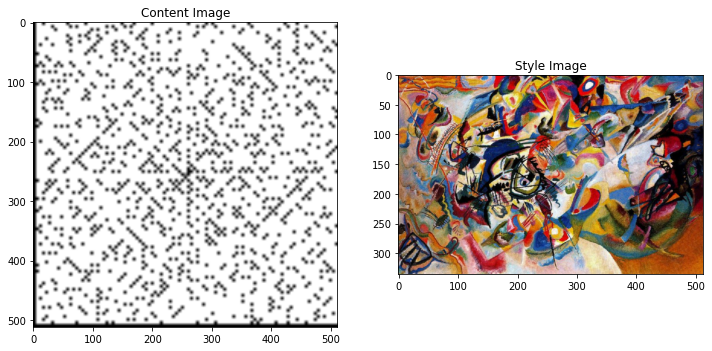

In [8]:
content_image = load_img(content_path)
style_image = load_img(style_path)

plt.subplot(1, 2, 1)
imshow(content_image, 'Content Image')

plt.subplot(1, 2, 2)
imshow(style_image, 'Style Image')


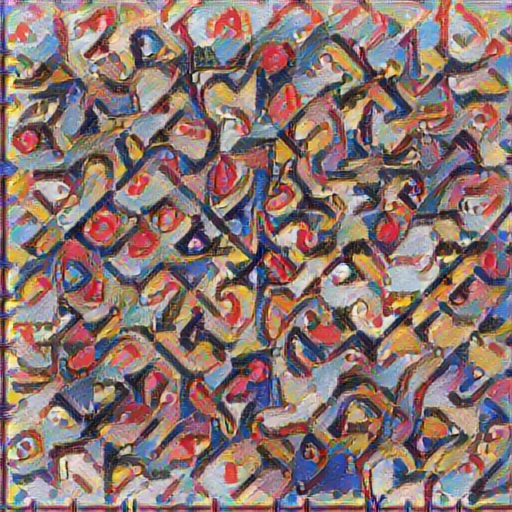

In [9]:
import tensorflow_hub as hub
hub_model = hub.load('https://tfhub.dev/google/magenta/arbitrary-image-stylization-v1-256/2')
stylized_image = hub_model(tf.constant(content_image), tf.constant(style_image))[0]
tensor_to_image(stylized_image)


#Wave Function Collapse


##Classes used (take from this github repo : https://github.com/Coac/wave-function-collapse )

In [10]:
import numpy as np
import os
from multiprocessing import Pool
import time

import matplotlib.pyplot as plt


In [11]:
class Pattern:
    """
    Pattern is a configuration of tiles from the input image.
    """
    index_to_pattern = {}
    color_to_index = {}
    index_to_color = {}

    def __init__(self, data, index):
        self.index = index
        self.data = np.array(data)
        self.legal_patterns_index = {}  # offset -> [pattern_index]

    def get(self, index=None):
        if index is None:
            return self.data.item(0)
        return self.data[index]

    def set_legal_patterns(self, offset, legal_patterns):
        self.legal_patterns_index[offset] = legal_patterns

    @property
    def shape(self):
        return self.data.shape

    def is_compatible(self, candidate_pattern, offset):
        """
        Check if pattern is compatible with a candidate pattern for a given offset
        :param candidate_pattern:
        :param offset:
        :return: True if compatible
        """
        assert (self.shape == candidate_pattern.shape)

        # Precomputed compatibility
        if offset in self.legal_patterns_index:
            return candidate_pattern.index in self.legal_patterns_index[offset]

        # Computing compatibility
        ok_constraint = True
        start = tuple([max(offset[i], 0) for i, _ in enumerate(offset)])
        end = tuple([min(self.shape[i] + offset[i], self.shape[i]) for i, _ in enumerate(offset)])
        for index in np.ndindex(end):  # index = (x, y, z...)
            start_constraint = True
            for i, d in enumerate(index):
                if d < start[i]:
                    start_constraint = False
                    break
            if not start_constraint:
                continue

            if candidate_pattern.get(tuple(np.array(index) - np.array(offset))) != self.get(index):
                ok_constraint = False
                break

        return ok_constraint

    def to_image(self):
        return Pattern.index_to_img(self.data)

    @staticmethod
    def from_sample(sample, pattern_size):
        """
        Compute patterns from sample
        :param pattern_size:
        :param sample:
        :return: list of patterns
        """

        sample = Pattern.sample_img_to_indexes(sample)

        shape = sample.shape
        patterns = []
        pattern_index = 0

        for index, _ in np.ndenumerate(sample):
            # Checking if index is out of bounds
            out = False
            for i, d in enumerate(index):  # d is a dimension, e.g.: x, y, z
                if d > shape[i] - pattern_size[i]:
                    out = True
                    break
            if out:
                continue

            pattern_location = [range(d, pattern_size[i] + d) for i, d in enumerate(index)]
            pattern_data = sample[np.ix_(*pattern_location)]

            datas = [pattern_data, np.fliplr(pattern_data)]
            
            # Checking existence
            # TODO: more probability to multiple occurrences when observe phase
            for data in datas:
                exist = False
                for p in patterns:
                    if (p.data == data).all():
                        exist = True
                        break
                if exist:
                    continue

                pattern = Pattern(data, pattern_index)
                patterns.append(pattern)
                Pattern.index_to_pattern[pattern_index] = pattern
                pattern_index += 1

        # Pattern.plot_patterns(patterns)
        return patterns

    @staticmethod
    def sample_img_to_indexes(sample):
        """
        Convert a rgb image to a 2D array with pixel index
        :param sample:
        :return: pixel index sample
        """
        Pattern.color_to_index = {}
        Pattern.index_to_color = {}
        sample_index = np.zeros(sample.shape[:-1])  # without last rgb dim
        color_number = 0
        for index in np.ndindex(sample.shape[:-1]):
            color = tuple(sample[index])
            if color not in Pattern.color_to_index:
                Pattern.color_to_index[color] = color_number
                Pattern.index_to_color[color_number] = color
                color_number += 1

            sample_index[index] = Pattern.color_to_index[color]

        return sample_index

    @staticmethod
    def index_to_img(sample):
        color = next(iter(Pattern.index_to_color.values()))

        image = np.zeros(sample.shape + (len(color),))
        for index in np.ndindex(sample.shape):
            pattern_index = sample[index]
            if pattern_index == -1:
                image[index] = [0.5 for _ in range(len(color))]  # Grey
            else:
                image[index] = Pattern.index_to_color[pattern_index]
        return image

    @staticmethod
    def from_index(pattern_index):
        return Pattern.index_to_pattern[pattern_index]

In [12]:
class Cell:
    """
    Cell is a pixel or tile (in 2d) that stores the possible patterns
    """

    def __init__(self, num_pattern, position, grid):
        self.num_pattern = num_pattern
        self.allowed_patterns = [i for i in range(self.num_pattern)]

        self.position = position
        self.grid = grid
        self.offsets = [(z, y, x) for x in range(-1, 2) for y in range(-1, 2) for z in range(-1, 2)]

    def entropy(self):
        return len(self.allowed_patterns)

    def choose_rnd_pattern(self):
        chosen_index = np.random.randint(len(self.allowed_patterns))
        self.allowed_patterns = [self.allowed_patterns[chosen_index]]

    def is_stable(self):
        return len(self.allowed_patterns) == 1

    def get_value(self):
        if self.is_stable():
            pattern = Pattern.from_index(self.allowed_patterns[0])
            return pattern.get()
        return -1

    def get_neighbors(self):
        neighbors = []
        for offset in self.offsets:
            neighbor_pos = tuple(np.array(self.position) + np.array(offset))
            out = False
            for i, d in enumerate(neighbor_pos):
                if not 0 <= d < self.grid.size[i]:
                    out = True
            if out:
                continue

            neighbors.append((self.grid.get_cell(neighbor_pos), offset))

        return neighbors

In [13]:
class Propagator:
    """
    Propagator that computes and stores the legal patterns relative to another
    """

    def __init__(self, patterns):
        self.patterns = patterns
        self.offsets = [(z, y, x) for x in range(-1, 2) for y in range(-1, 2) for z in range(-1, 2)]

        start_time = time.time()
        self.precompute_legal_patterns()

    def precompute_legal_patterns(self):
        pool = Pool(os.cpu_count())

        patterns_offsets = []
        for pattern in self.patterns:
            for offset in self.offsets:
                patterns_offsets.append((pattern, offset))

        patterns_compatibility = pool.starmap(self.legal_patterns, patterns_offsets)
        pool.close()
        pool.join()

        for pattern_index, offset, legal_patterns in patterns_compatibility:
            self.patterns[pattern_index].set_legal_patterns(offset, legal_patterns)

    def legal_patterns(self, pattern, offset):
        legal_patt = []
        for candidate_pattern in self.patterns:
            if pattern.is_compatible(candidate_pattern, offset):
                legal_patt.append(candidate_pattern.index)
        pattern.set_legal_patterns(offset, legal_patt)

        return pattern.index, offset, legal_patt

    @staticmethod
    def propagate(cell):
        to_update = [neighbour for neighbour, _ in cell.get_neighbors()]
        while len(to_update) > 0:
            cell = to_update.pop(0)
            for neighbour, offset in cell.get_neighbors():
                for pattern_index in cell.allowed_patterns:
                    pattern = Pattern.from_index(pattern_index)
                    pattern_still_compatible = False
                    for neighbour_pattern_index in neighbour.allowed_patterns:
                        neighbour_pattern = Pattern.from_index(neighbour_pattern_index)

                        if pattern.is_compatible(neighbour_pattern, offset):
                            pattern_still_compatible = True
                            break

                    if not pattern_still_compatible:
                        cell.allowed_patterns.remove(pattern_index)

                        for neigh, _ in cell.get_neighbors():
                            if neigh not in to_update:
                                to_update.append(neigh)

In [14]:
class Grid:
    """
    Grid is made of Cells
    """

    def __init__(self, size, num_pattern):
        self.size = size
        self.grid = np.empty(self.size, dtype=object)
        for position in np.ndindex(self.size):
            self.grid[position] = Cell(num_pattern, position, self)

        # self.grid = np.array([[Cell(num_pattern, (x, y), self) for x in range(self.size)] for y in range(self.size)])
        # self.grid = np.array([Cell(num_pattern, (x,), self) for x in range(self.size)])

    def find_lowest_entropy(self):
        min_entropy = 999999
        lowest_entropy_cells = []
        for cell in self.grid.flat:
            if cell.is_stable():
                continue

            entropy = cell.entropy()

            if entropy == min_entropy:
                lowest_entropy_cells.append(cell)
            elif entropy < min_entropy:
                min_entropy = entropy
                lowest_entropy_cells = [cell]

        if len(lowest_entropy_cells) == 0:
            return None
        cell = lowest_entropy_cells[np.random.randint(len(lowest_entropy_cells))]
        return cell

    def get_cell(self, index):
        """
        Returns the cell contained in the grid at the provided index
        :param index: (...z, y, x)
        :return: cell
        """
        return self.grid[index]

    def get_image(self):
        """
        Returns the grid converted from index to back to color
        :return:
        """
        image = np.vectorize(lambda c: c.get_value())(self.grid)
        image = Pattern.index_to_img(image)
        return image

    def check_contradiction(self):
        for cell in self.grid.flat:
            if len(cell.allowed_patterns) == 0:
                return True
        return False

    def print_allowed_pattern_count(self):
        grid_allowed_patterns = np.vectorize(lambda c: len(c.allowed_patterns))(self.grid)
        print(grid_allowed_patterns)

In [15]:
"""
Implementation of WaveFunctionCollapse
Following the "WaveFunctionCollapse is Constraint Solving in the Wild" terminology
"""

class WaveFunctionCollapse:
    """
    WaveFunctionCollapse encapsulates the wfc algorithm
    """

    def __init__(self, grid_size, sample, pattern_size):
        self.patterns = Pattern.from_sample(sample, pattern_size)
        self.grid = self._create_grid(grid_size)
        self.propagator = Propagator(self.patterns)

    def run(self):
        start_time = time.time()

        done = False
        while not done:
            done = self.step()

        print("WFC run took %s seconds" % (time.time() - start_time))

    def step(self):
        cell = self.observe()
        if cell is None:
            return True
        self.propagate(cell)
        return False

    def get_image(self):
        return self.grid.get_image()

    def get_patterns(self):
        return [pattern.to_image() for pattern in self.patterns]

    def observe(self):
        if self.grid.check_contradiction():
            return None
        cell = self.grid.find_lowest_entropy()

        if cell is None:
            return None

        cell.choose_rnd_pattern()

        return cell

    def propagate(self, cell):
        self.propagator.propagate(cell)

    def _create_grid(self, grid_size):
        num_pattern = len(self.patterns)
        return Grid(grid_size, num_pattern)

##Generating an image that ressembles the ulam spiral input
Making sure that the copied code works for my case

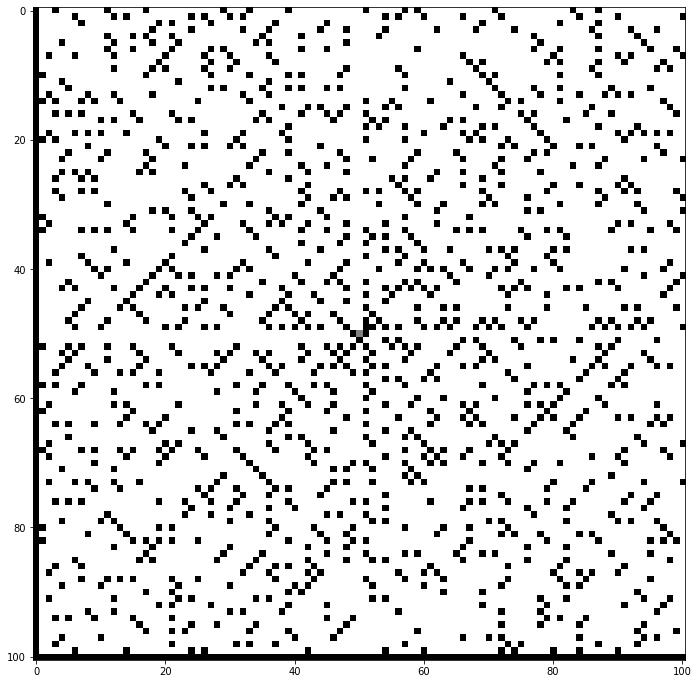

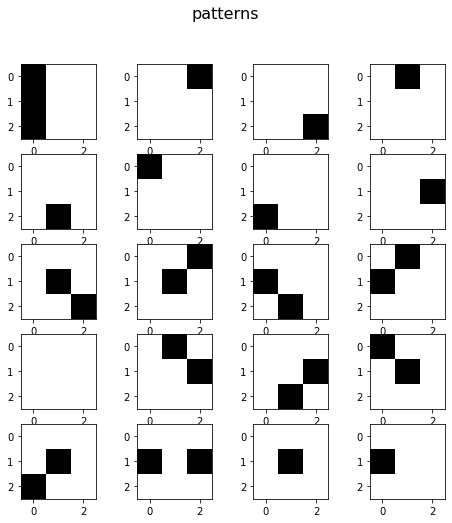

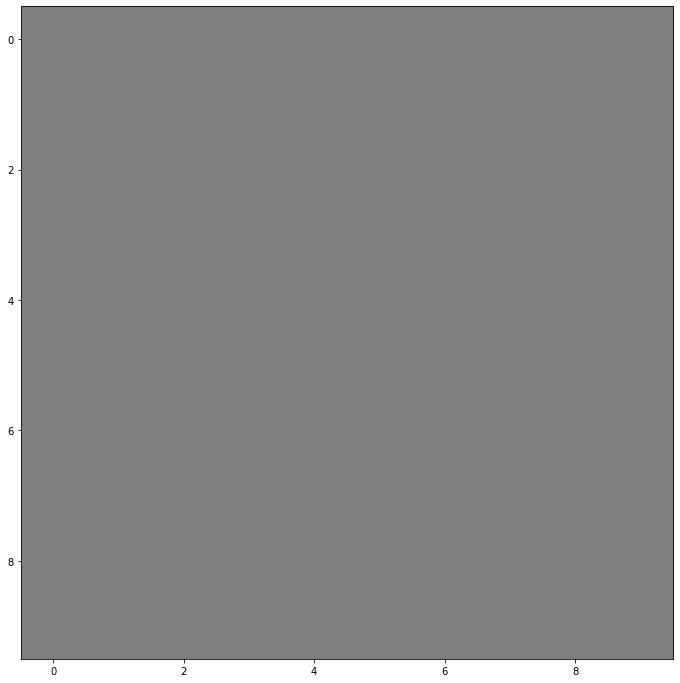

In [16]:
"""
An example of using the wave function collapse with 2D image.
"""

def plot_patterns(patterns, title=''):
    fig = plt.figure(figsize=(8, 8))
    fig.suptitle(title, fontsize=16)
    columns = 4
    rows = 5
    for i in range(1, columns * rows + 1):
        if i > len(patterns):
            break
        fig.add_subplot(rows, columns, i)
        show(patterns[i - 1])

    plt.show()


def load_sample(path):
    sample = plt.imread(path)
    
    if len(sample.shape) ==2 :
      sample = np.array([[[x,x,x] for x in sample_x] for sample_x in sample] )
    # Expand dim to 3D
    sample = np.expand_dims(sample, axis=0)
    
    sample = sample[:, :, :, :3]

    return sample


def show(image):
    if image.shape[0] == 1:
        return plt.imshow(np.squeeze(image, axis=0))


if __name__ == '__main__':

    grid_size = (1, 10, 10)
    pattern_size = (1, 3, 3)

    sample = load_sample('100.png')
    show(sample)
    plt.show()

    wfc = WaveFunctionCollapse(grid_size, sample, pattern_size)
    plot_patterns(wfc.get_patterns(), 'patterns')

    fig, ax = plt.subplots()
    image = wfc.get_image()
    im = show(image)
    while True:
        done = wfc.step()
        if done:
            break
        
        image = wfc.get_image()
        
        if image.shape[0] == 1:
            image = np.squeeze(image, axis=0)
            im.set_array(image)
        
        fig.canvas.draw()
        #plt.pause(0.001)

    plt.show()

##Generating images to pad the spiral image


array([[[0.        , 0.        , 0.        ],
        [1.        , 1.        , 1.        ],
        [1.        , 1.        , 1.        ],
        [1.        , 1.        , 1.        ],
        [0.        , 0.        , 0.        ],
        [1.        , 1.        , 1.        ],
        [0.        , 0.        , 0.        ],
        [1.        , 1.        , 1.        ],
        [1.        , 1.        , 1.        ],
        [1.        , 1.        , 1.        ]],

       [[1.        , 1.        , 1.        ],
        [1.        , 1.        , 1.        ],
        [1.        , 1.        , 1.        ],
        [1.        , 1.        , 1.        ],
        [1.        , 1.        , 1.        ],
        [0.        , 0.        , 0.        ],
        [1.        , 1.        , 1.        ],
        [1.        , 1.        , 1.        ],
        [1.        , 1.        , 1.        ],
        [0.        , 0.        , 0.        ]],

       [[1.        , 1.        , 1.        ],
        [1.        , 1.       

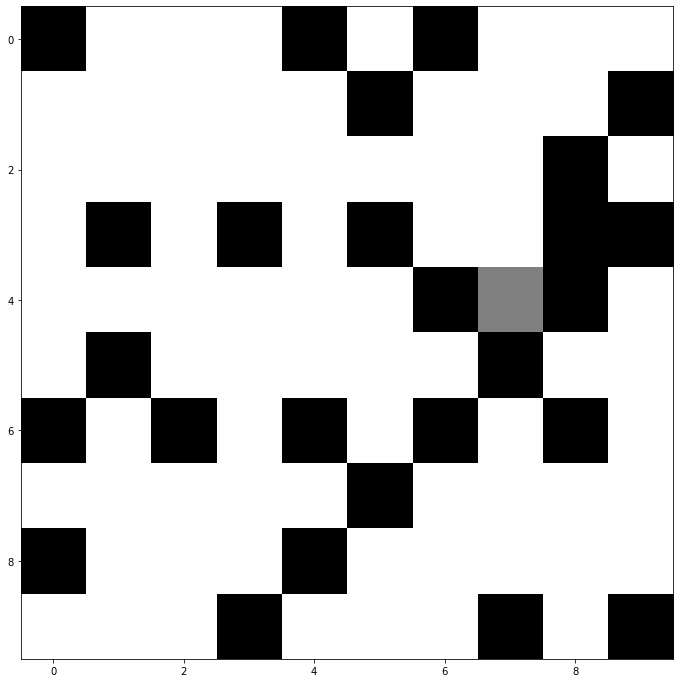

In [17]:
def wfc_function(path, pattern_size, grid_size):
  sample = load_sample(path)
  sample = sample[:,:-1,1:,:]
  wfc = WaveFunctionCollapse(grid_size, sample, pattern_size)

  fig, ax = plt.subplots()
  image = wfc.get_image()
  im = show(image)
  while True:
        done = wfc.step()
        if done:
            break
        
        image = wfc.get_image()
        
        if image.shape[0] == 1:
            image = np.squeeze(image, axis=0)
            im.set_array(image)
        
        fig.canvas.draw()
        #plt.pause(0.001)
  return image
wfc_function("100.png", pattern_size, grid_size)

In [18]:
def creating_images(path, completion_width):
  square_grid_size = (1, completion_width,completion_width)
  vertical_grid_size = (1, completion_width, ULA_SIZE)
  pattern_size = (1, 3, 3)

  square_image = wfc_function(path, pattern_size, square_grid_size)
  vertical_image = wfc_function(path, pattern_size, vertical_grid_size)
  horizontal_image = np.swapaxes(vertical_image, 1,0)

  return square_image, vertical_image, horizontal_image


##Putting these generated images around the original spiral

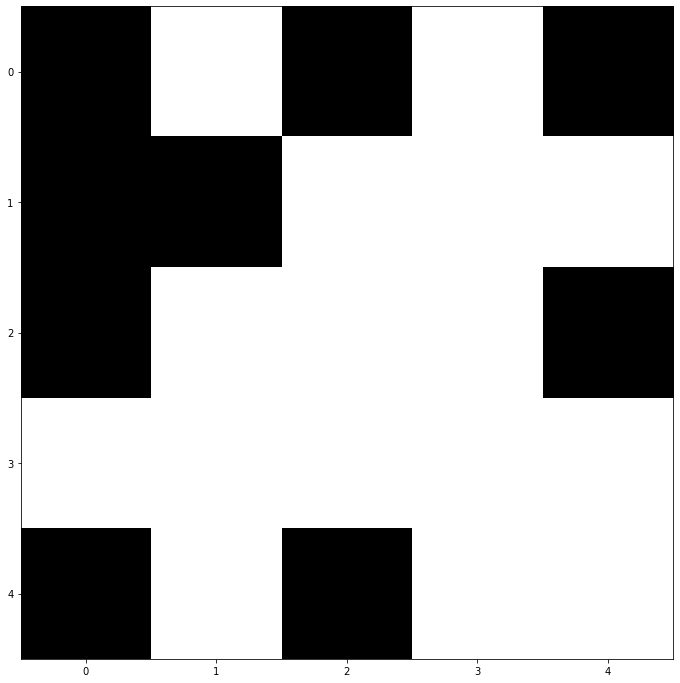

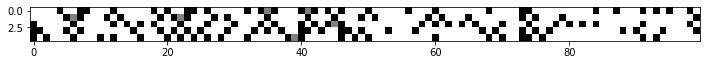

In [19]:
def complete_the_spiral(path, completion_width):
  sample = load_sample(path)
  sample = np.squeeze(sample)[:-1,1:,:]
  square_i, vertical_i, horizontal_i = creating_images(path, completion_width)
  
  upper_section = np.concatenate((square_i, horizontal_i, square_i), axis = 0)
  middle_section = np.concatenate((vertical_i, sample, vertical_i),axis = 0)
  bottom_section = np.concatenate((square_i, horizontal_i, square_i), axis = 0)

  completed_spiral = np.concatenate((upper_section, middle_section, bottom_section), axis = 1)
  return completed_spiral
completed_spiral = complete_the_spiral("100.png", 5)

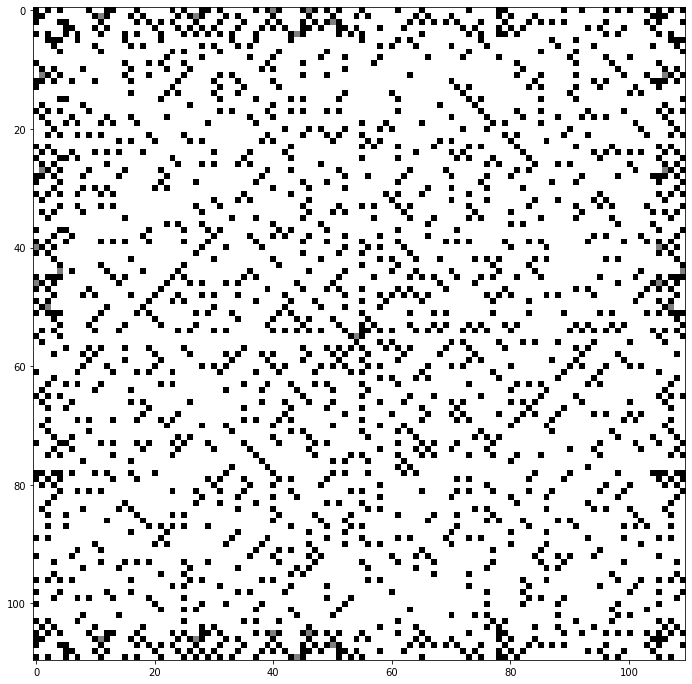

In [20]:
plt.imshow(completed_spiral)

##Caveats :
-Sometimes, the images generated by the wfc algorithm are composed of only grey pixels. Usually, re-executing the notebook entirely solves this issue. Maybe it happens when the wfc cannot converge on a stable state.